# Mr.HelpMate AI
##### By Mahalakshmi Totad

## Part 1: Project Introduction

#### Project Background

The goal of the project will be to build a robust generative search system capable of effectively and accurately answering questions from a policy document.

#### Problem Statement

*Given a policy document containing information about Life insurance, build a HelpMate AI that parses the filtered documents and provides answers to user's queries*.


### System Design:
#### The Project will have following layers:
1. The Embedding Layer : 
    - The PDF document needs to be effectively processed, cleaned, and chunked for the embeddings.
    - Will experiment and choose appropriate chunking strategy and embedding model.
    - 
2. The Search Layer
    - Sesign at least 3 queries against which to test the system.
    - Search  ChromaDB vector database against each of these queries. 
    - Implementing a cache mechanism
    - Implement the re-ranking block

3. The Generation Layer
    - Design the final prompt (exhaustive in its instructions, provide some few-shot examples etc)

## The Embedding Layer

### 1.  Install and Import the Required Libraries

In [7]:
# !pip install pyqt5
# !pip install typer
# !pip install typer==0.9.4

  Using cached typer-0.9.4-py3-none-any.whl (45 kB)
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastapi-cli 0.0.4 requires typer>=0.12.3, but you have typer 0.9.4 which is incompatible.


In [5]:
# Install all the required libraries
# !pip install -U -q pdfplumber tiktoken openai chromadb sentence-transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.


In [3]:
# !pip install typing_extensions==4.7.1 --upgrade


In [2]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [ ]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [244]:
# Define the path of the PDF
single_pdf_path = 'Principal-Sample-Life-Insurance-Policy.pdf'

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [7]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

#### <font color = red> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [245]:
# Define the path where all pdf documents are present
pdf_path = 'Principal-Sample-Life-Insurance-Policy.pdf'


In [10]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [11]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [12]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

All PDFs have been processed.


In [24]:
pdf_path[:-4]

'Principal-Sample-Life-Insurance-Policy'

In [246]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Call the function to extract the text from the PDF
extracted_text = extract_text_from_pdf(pdf_path)

# Convert the extracted list to a PDF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
extracted_text_df['Document Name'] = pdf_path[:-4]

# Append the extracted text and document name to the list
data.append(extracted_text_df)

# Print a message to indicate progress
print(f"Finished processing {pdf_path[:-4]}")

Finished processing Principal-Sample-Life-Insurance-Policy


In [26]:
data

[   Page No.                                          Page_Text  \
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
 1    Page 2                 This page left blank intentionally   
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
 3    Page 4                 This page left blank intentionally   
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
 ..      ...                                                ...   
 59  Page 60  I f a Dependent who was insured dies during th...   
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...   
 61  Page 62  A claimant may request an appeal of a claim de...   
 62  Page 63                 This page left blank intentionally   
 63  Page 64  Principal Life Insurance Company Des Moines, I...   
 
                              Document Name  
 0   Principal-Sample-Life-Insurance-Policy  
 1   Principal-Sample-Life-Insurance-Policy  
 2   Principal-Sample-Life-Insurance-Policy  
 3   Princ

In [27]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [28]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy


In [29]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [30]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [31]:
insurance_pdfs_data['Text_Length']

0      30
1       5
2     230
3       5
4     110
     ... 
59    285
60    418
61    322
62      5
63      8
Name: Text_Length, Length: 64, dtype: int64

In [32]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy,387
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy,251
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy,299
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy,352


In [33]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

/var/folders/mh/k723w1_x7d55dhf608rzfzrc0000gn/T/ipykernel_10540/1081778557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [37]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy,171,{'Policy_Name': 'Principal-Sample-Life-Insuran...
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy,387,{'Policy_Name': 'Principal-Sample-Life-Insuran...
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy,251,{'Policy_Name': 'Principal-Sample-Life-Insuran...
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy,299,{'Policy_Name': 'Principal-Sample-Life-Insuran...
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy,352,{'Policy_Name': 'Principal-Sample-Life-Insuran...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going around 500. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [247]:
# Set the API key
with open("OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [105]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [106]:
# Define the path where chroma collections will be stored

chroma_data_path = '/ChromaDB_Data'

In [107]:
chroma_data_path

'/ChromaDB_Data'

In [108]:
import chromadb

In [109]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [110]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [111]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Group_Insurance', embedding_function=embedding_function)

In [112]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [113]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

In [114]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.022469419986009598,
   0.01871146820485592,
   -0.02729734405875206,
   -0.031290166079998016,
   -0.0036731369327753782,
   0.027923669666051865,
   0.0008538575493730605,
   0.023656828328967094,
   -0.016571523621678352,
   0.004253792576491833,
   -0.005251998547464609,
   0.004058065824210644,
   -0.006273039150983095,
   0.023252326995134354,
   -0.011299951933324337,
   0.030977005138993263,
   0.002877181861549616,
   -0.024726800620555878,
   0.03055945597589016,
   0.007920404896140099,
   0.006413309834897518,
   0.01886804960668087,
   0.00953188817948103,
   0.012689611874520779,
   -0.012356876395642757,
   -0.009440548717975616,
   0.017889415845274925,
   -0.021686512976884842,
   0.023526344448328018,
   0.0030223457142710686,
   0.013283316045999527,
   -0.0145490150898695,
   -0.03361279144883156,
   -0.041180890053510666,
   -0.00845539104193449,
   0.013531235978007317,
   -0.0026716687716543674,
   -0.003868863452225923

In [115]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [116]:
cache_collection.peek()

{'ids': ['what is the period during which the policy is active and what are the conditions during it?'],
 'embeddings': [[-0.0034430623054504395,
   -0.0242194551974535,
   0.00534675270318985,
   -0.023850006982684135,
   -0.029172813519835472,
   0.0013409642269834876,
   -0.01743253506720066,
   -0.0007119596120901406,
   -0.019786063581705093,
   0.003858692944049835,
   0.012944409623742104,
   0.02259114198386669,
   -0.007607919164001942,
   0.013348067179322243,
   0.007785802241414785,
   -0.00200289417989552,
   0.009243074804544449,
   0.004563383292406797,
   0.013135976158082485,
   -0.005415169056504965,
   -0.019526081159710884,
   -0.003906584344804287,
   -0.03398933634161949,
   0.0030342736281454563,
   0.006027497351169586,
   -0.0056648897007107735,
   0.01967659778892994,
   -0.019279781728982925,
   0.008688900619745255,
   -0.005521215032786131,
   0.006181434262543917,
   -0.00940043292939663,
   -0.037191230803728104,
   -0.0014128015609458089,
   0.0066637708


## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.
- query 1 - what is the period during which the policy is active? and what are the conditions during it?
- query 2 - what is th coverage scope of the insuracne?
- query 3 - what are the things to take care of to make sure insuarnce can be claimed without issues?


## Query 1
    - what is the period during which the policy is active? and what are the conditions during it?

In [151]:
# Read the user query

query = input()

 what is the period during which the policy is active? and what are the conditions during it?


### Implementing cache

In [152]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [153]:
cache_results

{'ids': [['what is the period during which the policy is active and what are the conditions during it?']],
 'distances': [[0.006286149908528582]],
 'metadatas': [[{'distances0': '0.35631817038874974',
    'distances1': '0.3584570087932172',
    'distances2': '0.36464455224640085',
    'distances3': '0.36640026680044563',
    'distances4': '0.37586587690380124',
    'distances5': '0.38159815057417',
    'distances6': '0.3817851026078799',
    'distances7': '0.38199364119042095',
    'distances8': '0.382623142662059',
    'distances9': '0.3831200185351957',
    'documents0': 'Section D - Policy Renewal Article 1 - Renewal Insurance under this Group Policy runs annually to the Policy Anniversary, unless sooner terminated. While this Group Policy is in force, and subject to the provisions in PART II, Section C, the Policyholder may renew at the applicable premium rates in effect on the Policy Anniversary. This policy has been updated effective January 1, 2014 PART II - POLICY ADMINISTRATIO

In [154]:
results = insurance_collection.query(
query_texts=query1,
n_results=10
)
# results.items()

In [155]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(10):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Found in cache!


In [156]:
results_df

,IDs,Documents,Distances,Metadatas
0,22,Section D - Policy Renewal Article 1 - Renewal...,0.35631817038874974,"{'Page_No.': 'Page 25', 'Policy_Name': 'Princi..."
1,25,Section B - Effective Dates Article 1 - Member...,0.3584570087932172,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi..."
2,14,a. be actively engaged in business for profit ...,0.36464455224640085,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi..."
3,37,Section E - Reinstatement Article 1 - Reinstat...,0.36640026680044563,"{'Page_No.': 'Page 40', 'Policy_Name': 'Princi..."
4,21,T he Principal may terminate the Policyholder'...,0.37586587690380124,"{'Page_No.': 'Page 24', 'Policy_Name': 'Princi..."
5,17,Section B - Premiums Article 1 - Payment Respo...,0.38159815057417,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi..."
6,38,I f coverage for a Member or Dependent termina...,0.3817851026078799,"{'Page_No.': 'Page 41', 'Policy_Name': 'Princi..."
7,30,a . In no event will Dependent Life Insurance ...,0.38199364119042095,"{'Page_No.': 'Page 33', 'Policy_Name': 'Princi..."
8,40,Any individual policy issued will then be in f...,0.382623142662059,"{'Page_No.': 'Page 43', 'Policy_Name': 'Princi..."
9,28,Scheduled Benefit in force for the Member befo...,0.3831200185351957,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi..."


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

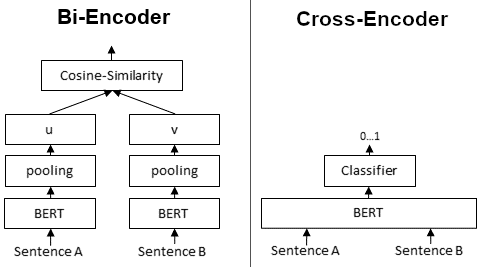

<br>

In [157]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [158]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [159]:
# Test the cross encoder model

# scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
#                                 ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [160]:
# scores

In [161]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query1, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [162]:
cross_rerank_scores

array([-11.394785, -10.980225, -10.939341, -10.877993, -11.20019 ,
       -11.19227 , -10.364315, -10.116587, -10.977716, -11.189447],
      dtype=float32)

In [163]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [164]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,22,Section D - Policy Renewal Article 1 - Renewal...,0.35631817038874974,"{'Page_No.': 'Page 25', 'Policy_Name': 'Princi...",-11.394785
1,25,Section B - Effective Dates Article 1 - Member...,0.3584570087932172,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",-10.980225
2,14,a. be actively engaged in business for profit ...,0.36464455224640085,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",-10.939341
3,37,Section E - Reinstatement Article 1 - Reinstat...,0.36640026680044563,"{'Page_No.': 'Page 40', 'Policy_Name': 'Princi...",-10.877993
4,21,T he Principal may terminate the Policyholder'...,0.37586587690380124,"{'Page_No.': 'Page 24', 'Policy_Name': 'Princi...",-11.200190
5,17,Section B - Premiums Article 1 - Payment Respo...,0.38159815057417,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",-11.192270
6,38,I f coverage for a Member or Dependent termina...,0.3817851026078799,"{'Page_No.': 'Page 41', 'Policy_Name': 'Princi...",-10.364315
7,30,a . In no event will Dependent Life Insurance ...,0.38199364119042095,"{'Page_No.': 'Page 33', 'Policy_Name': 'Princi...",-10.116587
8,40,Any individual policy issued will then be in f...,0.382623142662059,"{'Page_No.': 'Page 43', 'Policy_Name': 'Princi...",-10.977716
9,28,Scheduled Benefit in force for the Member befo...,0.3831200185351957,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",-11.189447


## Query 1 Results
    - what is the period during which the policy is active? and what are the conditions during it?

In [167]:
# Return the top 3 results from semantic search
top_3_semantic_query = results_df.sort_values(by='Distances')
top_3_semantic_query[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,22,Section D - Policy Renewal Article 1 - Renewal...,0.35631817038874974,"{'Page_No.': 'Page 25', 'Policy_Name': 'Princi...",-11.394785
1,25,Section B - Effective Dates Article 1 - Member...,0.3584570087932172,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",-10.980225
2,14,a. be actively engaged in business for profit ...,0.36464455224640085,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",-10.939341


In [168]:
# Return the top 3 results after reranking

top_3_rerank_query = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_query[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
7,30,a . In no event will Dependent Life Insurance ...,0.38199364119042095,"{'Page_No.': 'Page 33', 'Policy_Name': 'Princi...",-10.116587
6,38,I f coverage for a Member or Dependent termina...,0.3817851026078799,"{'Page_No.': 'Page 41', 'Policy_Name': 'Princi...",-10.364315
3,37,Section E - Reinstatement Article 1 - Reinstat...,0.36640026680044563,"{'Page_No.': 'Page 40', 'Policy_Name': 'Princi...",-10.877993


In [169]:
top_3_RAG_query = top_3_rerank[["Documents", "Metadatas"]][:3]

In [170]:
top_3_RAG_query

,Documents,Metadatas
7,a . In no event will Dependent Life Insurance ...,"{'Page_No.': 'Page 33', 'Policy_Name': 'Princi..."
6,I f coverage for a Member or Dependent termina...,"{'Page_No.': 'Page 41', 'Policy_Name': 'Princi..."
3,Section E - Reinstatement Article 1 - Reinstat...,"{'Page_No.': 'Page 40', 'Policy_Name': 'Princi..."


## Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [171]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

## Query 1 Results
    - what is the period during which the policy is active? and what are the conditions during it?

In [172]:
# Generate the response

response = generate_response(query, top_3_RAG_query)

In [173]:
# Print the response

print("\n".join(response))

The period during which the policy is active is typically mentioned in the policy document under the section titled "Policy Term" or "Coverage Period." This section outlines the duration for which the policy is in effect. It may specify the start date and end date of the coverage period.

Additionally, the conditions during the policy period are usually detailed in the "Policy Conditions" or "Coverage Conditions" section. This part of the document lists the requirements and obligations that the policyholder must adhere to during the active policy period. It can include information on premium payments, coverage limits, exclusions, claim procedures, and other relevant terms.

If you are looking for specific details or want to understand the exact terms related to the policy period and conditions, it is recommended to refer to the policy document provided to you.

---

Citation:
- Policy Name(s): Principal Group Insurance Policy Rider
- Page Number(s): Page 3


## Query 2
    - what is th coverage scope of the insuracne?

In [208]:
# Read the user query

query = input()

 what is th coverage scope of the insuracne?


In [209]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [210]:
cache_results

{'ids': [['what is th coverage scope of the insuracne?']],
 'distances': [[0.0]],
 'metadatas': [[{'distances0': '0.3825380506387041',
    'distances1': '0.3948042803294191',
    'distances2': '0.4012911294169943',
    'distances3': '0.4021350219691328',
    'distances4': '0.4073447106473896',
    'distances5': '0.4108022190836728',
    'distances6': '0.4108418194214784',
    'distances7': '0.4129616167041816',
    'distances8': '0.413761289585574',
    'distances9': '0.41468157278145346',
    'documents0': "a. be actively engaged in business for profit within the meaning of the Internal Revenue Code, or be established as a legitimate nonprofit corporation within the meaning of the Internal Revenue Code; and b. make at least the level of premium contributions required for insurance on its eligible Members. The Policyholder must: (1) contribute at least 50% of the required premium for all Members (including disabled Members, if any); and c. if the Member is to contribute part of the pre

In [211]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
# results.items()

In [212]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(10):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Found in cache!


In [213]:
results_df

,IDs,Documents,Distances,Metadatas
0,14,a. be actively engaged in business for profit ...,0.3825380506387041,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi..."
1,50,Section B - Member Accidental Death and Dismem...,0.3948042803294191,"{'Page_No.': 'Page 53', 'Policy_Name': 'Princi..."
2,15,c . a copy of the form which contains the stat...,0.4012911294169943,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi..."
3,52,Exposure Exposure to the elements will be pres...,0.4021350219691328,"{'Page_No.': 'Page 55', 'Policy_Name': 'Princi..."
4,1,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,0.4073447106473896,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip..."
5,29,(1) marriage or establishment of a Civil Union...,0.4108022190836728,"{'Page_No.': 'Page 32', 'Policy_Name': 'Princi..."
6,43,PART IV - BENEFITS Section A - Member Life Ins...,0.4108418194214784,"{'Page_No.': 'Page 46', 'Policy_Name': 'Princi..."
7,51,"f . claim requirements listed in PART IV, Sect...",0.4129616167041816,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi..."
8,35,Section D - Continuation Article 1 - Member Li...,0.413761289585574,"{'Page_No.': 'Page 38', 'Policy_Name': 'Princi..."
9,56,Section C - Dependent Life Insurance Article 1...,0.41468157278145346,"{'Page_No.': 'Page 59', 'Policy_Name': 'Princi..."


<font color = red> Re-Ranking with a Cross Encoder



In [214]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [215]:
cross_rerank_scores

array([-10.939341, -11.119135, -10.788167, -11.153735, -10.219603,
       -10.510237, -11.175452, -10.977587, -11.113058, -11.23279 ],
      dtype=float32)

In [216]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [217]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,14,a. be actively engaged in business for profit ...,0.3825380506387041,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",-10.939341
1,50,Section B - Member Accidental Death and Dismem...,0.3948042803294191,"{'Page_No.': 'Page 53', 'Policy_Name': 'Princi...",-11.119135
2,15,c . a copy of the form which contains the stat...,0.4012911294169943,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",-10.788167
3,52,Exposure Exposure to the elements will be pres...,0.4021350219691328,"{'Page_No.': 'Page 55', 'Policy_Name': 'Princi...",-11.153735
4,1,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,0.4073447106473896,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",-10.219603
5,29,(1) marriage or establishment of a Civil Union...,0.4108022190836728,"{'Page_No.': 'Page 32', 'Policy_Name': 'Princi...",-10.510237
6,43,PART IV - BENEFITS Section A - Member Life Ins...,0.4108418194214784,"{'Page_No.': 'Page 46', 'Policy_Name': 'Princi...",-11.175452
7,51,"f . claim requirements listed in PART IV, Sect...",0.4129616167041816,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...",-10.977587
8,35,Section D - Continuation Article 1 - Member Li...,0.413761289585574,"{'Page_No.': 'Page 38', 'Policy_Name': 'Princi...",-11.113058
9,56,Section C - Dependent Life Insurance Article 1...,0.41468157278145346,"{'Page_No.': 'Page 59', 'Policy_Name': 'Princi...",-11.232790


## Query 2 Results
    - what is th coverage scope of the insuracne?

In [248]:
# Return the top 3 results from semantic search

top_3_semantic_query = results_df.sort_values(by='Distances')
top_3_semantic_query[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,14,a. be actively engaged in business for profit ...,0.3734623212052319,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",-9.193928
1,15,c . a copy of the form which contains the stat...,0.38539603641136766,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",-9.007393
2,58,Section D - Claim Procedures Article 1 - Notic...,0.3994354497538304,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi...",-8.097582


In [219]:
# Return the top 3 results after reranking

top_3_rerank_query = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_query[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
4,1,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,0.4073447106473896,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",-10.219603
5,29,(1) marriage or establishment of a Civil Union...,0.4108022190836728,"{'Page_No.': 'Page 32', 'Policy_Name': 'Princi...",-10.510237
2,15,c . a copy of the form which contains the stat...,0.4012911294169943,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",-10.788167


In [220]:
top_3_RAG_query = top_3_rerank_query[["Documents", "Metadatas"]][:3]

In [221]:
top_3_RAG_query

,Documents,Metadatas
4,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip..."
5,(1) marriage or establishment of a Civil Union...,"{'Page_No.': 'Page 32', 'Policy_Name': 'Princi..."
2,c . a copy of the form which contains the stat...,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi..."


### Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [189]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

## Query 2 Results
    - what is th coverage scope of the insuracne?

In [190]:
# Generate the response

response = generate_response(query, top_3_RAG_query)

In [191]:
# Print the response

print("\n".join(response))

The coverage scope of the insurance policy includes the following aspects:
1. Policy Rider Group Insurance Policy No: S655
2. Coverage for marriage or establishment of a Civil Union
3. Form containing statistical data

Here is the information extracted from the documents to address your query:

| Coverage Aspect                                            | Policy Name           | Page Number |
|------------------------------------------------------------|-----------------------|-------------|
| Policy Rider Group Insurance Policy No: S655               | Principal Policy      | Page 3      |
| Marriage or establishment of a Civil Union                 | Principal Policy      | Page 32     |
| Form containing statistical data                           | Principal Policy      | Page 18     |

If you need more detailed information on the coverage scope, you can refer to the respective pages mentioned above in the Principal Policy document.


## Query 3
    - what are the things to take care of to make sure insurance can be claimed without issues?


In [227]:
# Read the user query

query = input()

 what are the things to take care of to make sure insurance can be claimed without issues?


In [228]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [229]:
cache_results

{'ids': [['what are the things to take care of to make sure insurance can be claimed without issues?']],
 'distances': [[1.8141727791733645e-06]],
 'metadatas': [[{'distances0': '0.3734623212052319',
    'distances1': '0.38539603641136766',
    'distances2': '0.3994354497538304',
    'distances3': '0.40614829947872244',
    'distances4': '0.406647986037606',
    'distances5': '0.4137261597764793',
    'distances6': '0.41770956149736366',
    'distances7': '0.41821185370791103',
    'distances8': '0.4186462765855613',
    'distances9': '0.4231969127409523',
    'documents0': "a. be actively engaged in business for profit within the meaning of the Internal Revenue Code, or be established as a legitimate nonprofit corporation within the meaning of the Internal Revenue Code; and b. make at least the level of premium contributions required for insurance on its eligible Members. The Policyholder must: (1) contribute at least 50% of the required premium for all Members (including disabled Mem

In [230]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
# results.items()

In [231]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(10):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Found in cache!


In [232]:
results_df

,IDs,Documents,Distances,Metadatas
0,14,a. be actively engaged in business for profit ...,0.3734623212052319,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi..."
1,15,c . a copy of the form which contains the stat...,0.38539603641136766,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi..."
2,58,Section D - Claim Procedures Article 1 - Notic...,0.3994354497538304,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi..."
3,19,The number of Members insured for Dependent Li...,0.40614829947872244,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi..."
4,59,A claimant may request an appeal of a claim de...,0.406647986037606,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi..."
5,26,Insurance for which Proof of Good Health is re...,0.4137261597764793,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi..."
6,37,Section E - Reinstatement Article 1 - Reinstat...,0.41770956149736366,"{'Page_No.': 'Page 40', 'Policy_Name': 'Princi..."
7,3,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.41821185370791103,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip..."
8,51,"f . claim requirements listed in PART IV, Sect...",0.4186462765855613,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi..."
9,10,a . A licensed Doctor of Medicine (M.D.) or Os...,0.4231969127409523,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi..."


<font color = red> Re-Ranking with a Cross Encoder



In [233]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [234]:
cross_rerank_scores

array([ -9.193928 ,  -9.007393 ,  -8.097582 ,  -9.580186 ,  -9.313737 ,
        -7.8482513,  -9.731878 , -11.352361 ,  -8.466997 , -11.100977 ],
      dtype=float32)

In [235]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [236]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,14,a. be actively engaged in business for profit ...,0.3734623212052319,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",-9.193928
1,15,c . a copy of the form which contains the stat...,0.38539603641136766,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",-9.007393
2,58,Section D - Claim Procedures Article 1 - Notic...,0.3994354497538304,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi...",-8.097582
3,19,The number of Members insured for Dependent Li...,0.40614829947872244,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi...",-9.580186
4,59,A claimant may request an appeal of a claim de...,0.406647986037606,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi...",-9.313737
5,26,Insurance for which Proof of Good Health is re...,0.4137261597764793,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi...",-7.848251
6,37,Section E - Reinstatement Article 1 - Reinstat...,0.41770956149736366,"{'Page_No.': 'Page 40', 'Policy_Name': 'Princi...",-9.731878
7,3,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.41821185370791103,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip...",-11.352361
8,51,"f . claim requirements listed in PART IV, Sect...",0.4186462765855613,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...",-8.466997
9,10,a . A licensed Doctor of Medicine (M.D.) or Os...,0.4231969127409523,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",-11.100977


## Query 3 Results
    - what are the things to take care of to make sure insurance can be claimed without issues?


In [249]:
# Return the top 3 results from semantic search

top_3_semantic_query = results_df.sort_values(by='Distances')
top_3_semantic_query[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,14,a. be actively engaged in business for profit ...,0.3734623212052319,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",-9.193928
1,15,c . a copy of the form which contains the stat...,0.38539603641136766,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",-9.007393
2,58,Section D - Claim Procedures Article 1 - Notic...,0.3994354497538304,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi...",-8.097582


In [238]:
# Return the top 3 results after reranking

top_3_rerank_query = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_query[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
5,26,Insurance for which Proof of Good Health is re...,0.4137261597764793,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi...",-7.848251
2,58,Section D - Claim Procedures Article 1 - Notic...,0.3994354497538304,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi...",-8.097582
8,51,"f . claim requirements listed in PART IV, Sect...",0.4186462765855613,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...",-8.466997


In [239]:
top_3_RAG_query = top_3_rerank_query[["Documents", "Metadatas"]][:3]

In [240]:
top_3_RAG_query

,Documents,Metadatas
5,Insurance for which Proof of Good Health is re...,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi..."
2,Section D - Claim Procedures Article 1 - Notic...,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi..."
8,"f . claim requirements listed in PART IV, Sect...","{'Page_No.': 'Page 54', 'Policy_Name': 'Princi..."


### Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [241]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

## Query 3 Results
    - what are the things to take care of to make sure insurance can be claimed without issues?


In [242]:
# Generate the response

response = generate_response(query, top_3_RAG_query)

In [243]:
# Print the response

print("\n".join(response))

To ensure that insurance claims can be processed smoothly without any issues, it is important to take care of the following:

1. Familiarize yourself with the policy terms and conditions.
2. Ensure timely premium payments to keep the policy active.
3. Provide accurate and complete information when submitting a claim.
4. Keep all relevant documents organized and easily accessible.
5. Notify the insurance company promptly in case of a claim.

Regarding the requested policy names and page numbers for further reference:

- Policy Name: Princip Group Insurance Policy
  Page Number: Page 3

- Policy Name: Princip Group Insurance Policy
  Page Number: Page 18

- Policy Name: Princip Group Insurance Policy
  Page Number: Page 32

I hope this information helps you understand how to ensure a hassle-free insurance claim process. If you need more specific details, refer to the mentioned policy documents for comprehensive guidance.


#### Challenges Faced
    - Choosing the appropriate Embedding model and chunking strategy to have relavant data in proper chunks
    - Choosing the right reranking strategy so that it gives proper chunks as results.